In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
Renewable_Energy = "Wind_Wallonie_Elia_"
unit = 4 #unit: 15 minute
E_max_lst = [0.1, 0.2, 0.3, 0.4, 0.5]
E_max = 0.3; E_maxi = E_max_lst.index(E_max)
Model = ["NEC", "ECC+", "DeepComp"]
model = ['NEC-', 'NEC', 'ECC', 'ECC+', 'DeepComp']
model_name = ['Battery-no-use', 'NEC', 'ECC', 'ECC+', 'DeepComp']

address = "https://raw.githubusercontent.com/Jaeik-Jeong/DeepComp/main/results/"
data_real_csv = pd.read_csv(address+Renewable_Energy+'19.csv', index_col=0)

# Real Data
RE_Capacity = max(data_real_csv['Power(MW)'])
data_real0 = []; data_real  = []; hour = []
size_real0 = int(len(data_real_csv)/unit)
for i in range(size_real0):
    data_real0 += [round(pd.Series.mean(data_real_csv['Power(MW)'][i*unit:(i+1)*unit])/RE_Capacity, 3)]
    data_real  += [data_real0[i]] if data_real0[i] > 0 else []
    hour       += [i] if data_real0[i] > 0 else []
data_real = np.reshape(np.array(data_real), (len(data_real),1))
data = [data_real[1:].flatten().tolist()]; col = ['Real']

# Forecasted Data
all_files = ['1_NEC.csv',
             '2_ECC+_10.csv', '2_ECC+_20.csv', '2_ECC+_30.csv', '2_ECC+_40.csv', '2_ECC+_50.csv',
             '3_DeepComp_10.csv', '3_DeepComp_20.csv', '3_DeepComp_30.csv', '3_DeepComp_40.csv', '3_DeepComp_50.csv']
for i in range(len(all_files)):
    col += ['Model'+all_files[i].replace('.csv','')]
    data += [pd.read_csv(address+Renewable_Energy+'Model'+all_files[i], index_col=0)['0'].tolist()]
data = pd.DataFrame(data, index=col).T

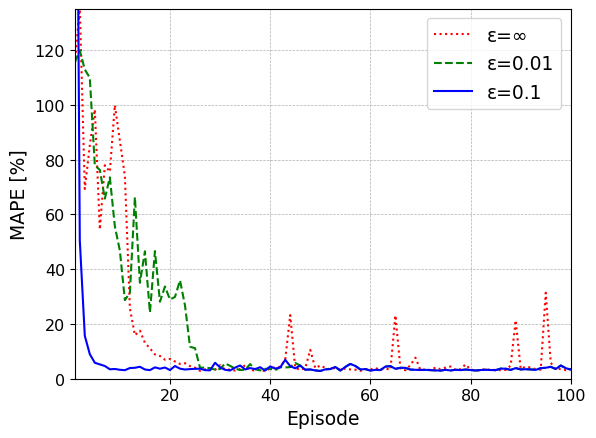

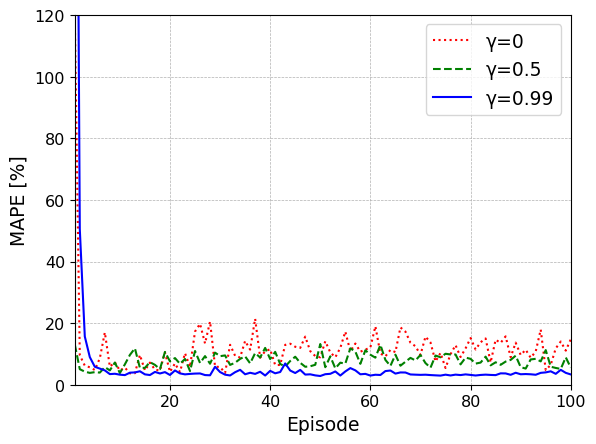

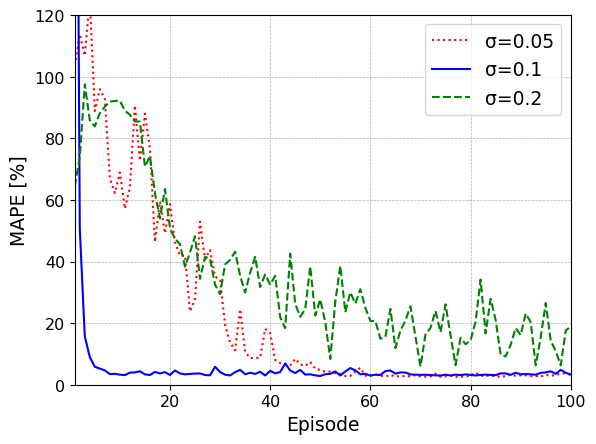

In [3]:
# epsilon = 0.01, 0.1, ∞
# gamma = 0, 0.5, 0.99
# std = 0.05, 0.2, 0.1

model_selection = pd.read_csv(address+Renewable_Energy+'Model0_Selection.csv', index_col=0)

w = model_selection['w']
w_ei = model_selection['w_ei']
w_e1 = model_selection['w_e1']
w_g0 = model_selection['w_g0']
w_g5 = model_selection['w_g5']
w_d5 = model_selection['w_d5']
w_d2 = model_selection['w_d2']

fig_val_epsilon2 = plt.figure()
plt.plot(range(1,101), w_ei, 'r:', linewidth=1.5, label='ε=∞')
plt.plot(range(1,101), w_e1, 'g--', linewidth=1.5, label='ε=0.01')
plt.plot(range(1,101), w, 'b', linewidth=1.5, label='ε=0.1')
plt.xticks(fontsize = 11.5)
plt.yticks(fontsize = 11.5)
plt.xlabel("Episode", fontsize=13.5)
plt.ylabel("MAPE [%]", fontsize=13.5)
plt.xlim(1,100)
plt.ylim(0,135)
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=13.5, loc=1)
plt.show()

fig_val_gamma2 = plt.figure()
plt.plot(range(1,101), w_g0, 'r:', linewidth=1.5, label='γ=0')
plt.plot(range(1,101), w_g5, 'g--', linewidth=1.5, label='γ=0.5')
plt.plot(range(1,101), w, 'b', linewidth=1.5, label='γ=0.99')
plt.xticks(fontsize = 11.5)
plt.yticks(fontsize = 11.5)
plt.xlabel("Episode", fontsize=13.5)
plt.ylabel("MAPE [%]", fontsize=13.5)
plt.xlim(1,100)
plt.ylim(0,120)
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=13.5, loc=1)
plt.show()

fig_val_std2 = plt.figure()
plt.plot(range(1,101), w_d5, 'r:', linewidth=1.5, label='σ=0.05')
plt.plot(range(1,101), w, 'b', linewidth=1.5, label='σ=0.1')
plt.plot(range(1,101), w_d2, 'g--', linewidth=1.5, label='σ=0.2')
plt.xticks(fontsize = 11.5)
plt.yticks(fontsize = 11.5)
plt.xlabel("Episode", fontsize=13.5)
plt.ylabel("MAPE [%]", fontsize=13.5)
plt.xlim(1,100)
plt.ylim(0,120)
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=13.5, loc=1)
plt.show()

In [4]:
metric = ['MAPE: ', 'CCR: ']
 
tdelta  = unit/4
eff_c   = 0.9
eff_d   = 0.9
soc_min = 0.1
soc_max = 0.9
 
Results_index = [metric[j] + model_name[m] for j in range(len(metric)) for m in range(len(model_name))]
Results = []
mape   = [np.zeros((len(data),len(model))) for _ in range(len(E_max_lst))] # Mean Absolute Percentage Error
ccr    = [np.zeros((len(data),len(model))) for _ in range(len(E_max_lst))] # Complete Compensation Ratio
scaled = [np.zeros((len(data),len(model))) for _ in range(len(E_max_lst))]
Disp = [np.zeros((len(data),len(model))) for _ in range(len(E_max_lst))]
Pred = [np.zeros((len(data),len(model))) for _ in range(len(E_max_lst))]
Ess  = [np.zeros((len(data),len(model))) for _ in range(len(E_max_lst))]
MAPE = [0 for _ in range(len(E_max_lst))]
CCR  = [0 for _ in range(len(E_max_lst))]
 
for e, E in enumerate(E_max_lst):
    P_cmax  = E/3
    P_dmax  = E/3
    
    state = [0, E/2]
    for m in range(len(model)):
        for i in range(len(data)):
            pred = data['Model1_NEC'][i]
            real = data['Real'][i]
 
            if Model[0] in model[m]:
                E_s = state[1]
                P_climit = min(P_cmax, (1/eff_c)*(E*soc_max - E_s)/tdelta)
                P_dlimit = min(P_dmax, eff_d*(E_s - E*soc_min)/tdelta)
                if '-' in model[m]:
                    P_climit = 0; P_dlimit = 0
                P_c = min(max(real-pred, 0), P_climit)
                P_d = min(max(pred-real, 0), P_dlimit)
                next_state = [real, E_s + eff_c*P_c*tdelta - (1/eff_d)*P_d*tdelta]
            
            if Model[1][0:3] in model[m]:
                c = [model[m][0:3] in col[j] and '_'+str(int(100*E)) in col[j] for j in range(len(col))].index(True)
                charge = data[col[c]][i]
                real = max(real + eff_d*max(-charge, 0.0)/tdelta - (1/eff_c)*max(charge, 0.0)/tdelta, 0.0)
 
                Es = state[1] + charge
                P_climit = min(P_cmax, (1/eff_c)*(E*soc_max - Es)/tdelta)
                P_dlimit = min(P_dmax, eff_d*(Es - E*soc_min)/tdelta)
                P_c = min(max(real-pred, 0), P_climit)
                P_d = min(max(pred-real, 0), P_dlimit)
                next_state = [real, Es + eff_c*P_c*tdelta - (1/eff_d)*P_d*tdelta]
                if '+' not in model[m] and E != 0:
                    D = 2*int(1000*E)
                    P_clist = np.array([(j/D)*P_climit for j in range(D+1)])
                    P_dlist = np.array([(j/D)*P_dlimit for j in range(D+1)])
                    P_c = P_clist[np.argmin(np.abs(P_clist - P_c))]
                    P_d = P_dlist[np.argmin(np.abs(P_dlist - P_d))]
 
            if Model[2] in model[m]:
                c = [model[m][0:3] in col[j] and '_'+str(int(100*E)) in col[j] for j in range(len(col))].index(True)
                pred = data[col[c]][i]
 
                Es = state[1]
                P_climit = min(P_cmax, (1/eff_c)*(E*soc_max - Es)/tdelta)
                P_dlimit = min(P_dmax, eff_d*(Es - E*soc_min)/tdelta)
                P_c = min(max(real-pred, 0), P_climit)
                P_d = min(max(pred-real, 0), P_dlimit)
                next_state = [real, Es + eff_c*P_c*tdelta - (1/eff_d)*P_d*tdelta]
 
            disp = 0.0 if np.isclose(real - P_c + P_d, 0) else real - P_c + P_d
            error = pred - disp
 
            mape[e][i][m]   = abs((pred-disp)/disp) if disp != 0 else 0
            ccr[e][i][m]    = 1 if np.isclose(pred-disp,0) else 0
            scaled[e][i][m] = (2*pred - (2*real - P_climit + P_dlimit))/(P_climit + P_dlimit + 1e-10)
            Disp[e][i][m]   = disp
            Pred[e][i][m]   = pred
            Ess[e][i][m]    = state[1]
 
            state = next_state[:]
  
    MAPE[e]  = np.round(100*np.mean(mape[e], axis=0), 2)
    CCR[e] = np.round(np.mean(ccr[e], axis=0), 3)
 
    Results += [np.append(MAPE[e], CCR[e])]
 
eval_dic = {}
for e in range(len(E_max_lst)):
    eval_dic[str(E_max_lst[e]) + ' p.u.'] = Results[e]
eval_df = pd.DataFrame(eval_dic, index = Results_index)
eval_df

,0.1 p.u.,0.2 p.u.,0.3 p.u.,0.4 p.u.,0.5 p.u.
MAPE: Battery-no-use,52.100,52.100,52.100,52.100,52.100
MAPE: NEC,21.110,15.780,13.910,13.050,12.470
MAPE: ECC,16.850,11.810,6.300,4.630,4.020
MAPE: ECC+,15.990,11.270,5.920,4.230,3.640
MAPE: DeepComp,14.340,7.760,3.600,2.110,1.220
CCR: Battery-no-use,0.000,0.000,0.000,0.000,0.000
CCR: NEC,0.438,0.606,0.700,0.748,0.784
CCR: ECC,0.021,0.024,0.025,0.025,0.025
CCR: ECC+,0.441,0.637,0.753,0.811,0.845
CCR: DeepComp,0.475,0.693,0.823,0.875,0.939


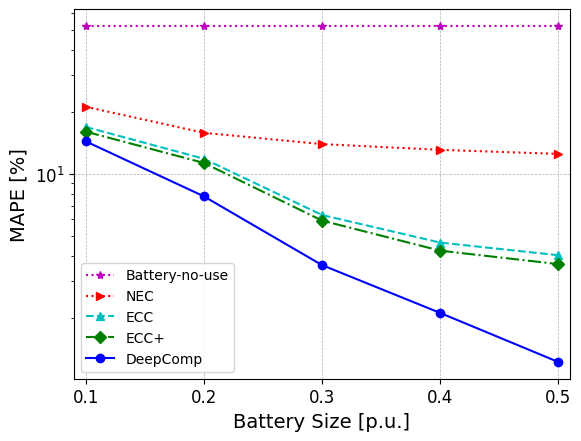

In [5]:
color = ["m", "r", "c", "g", "b"]
colorl = ["m:", "r:", "c--", "g-.", "b"]
marker = ['*', '>', '^', 'D', 'o']

fig_mape = plt.figure()
for m in range(len(model)):
    plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], np.transpose(MAPE)[m], colorl[m], marker=marker[m], label=model_name[m])
    plt.yscale("log")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Battery Size [p.u.]", fontsize=14)
plt.ylabel("MAPE [%]", fontsize=14)
plt.xlim([0.09,0.51])
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5])
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=10, loc=3)
plt.show()

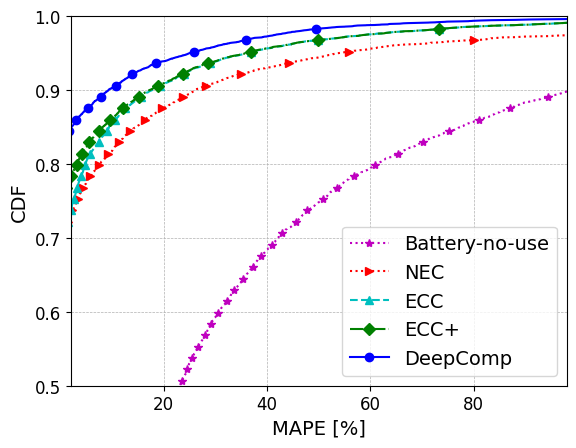

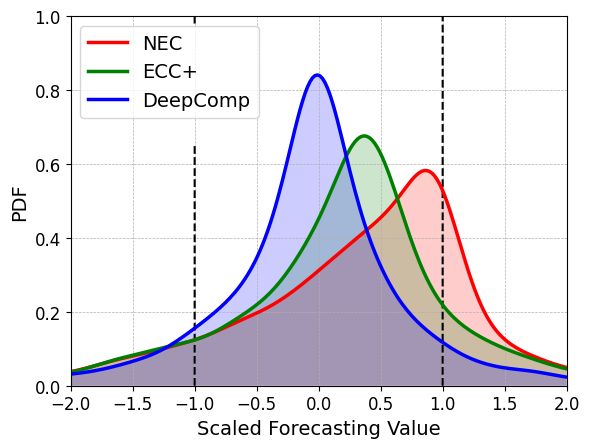

In [6]:
cdf = []
for m in range(len(model)):
    cdf += [np.arange(1, len(mape[E_maxi][:,m])+1) / len(mape[E_maxi][:,m])]

fig_cdf = plt.figure()
for m in range(len(model)):
    plt.plot(np.sort(100*mape[E_maxi][:,m]), cdf[m], colorl[m], marker=marker[m], markevery=128, markersize=6, label=model_name[m])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("MAPE [%]", fontsize=14)
plt.ylabel("CDF", fontsize=14)
plt.xlim([2,98])
plt.ylim([0.5,1.0])
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=14, loc=4)
plt.show()

xs = np.linspace(-2.0, 2.0, 200)
pdf_pred = []
for M in range(len(Model)):
    j = model_name.index(Model[M])
    pdf_pred += [gaussian_kde(scaled[E_maxi][:,j])]

fig_pdf = plt.figure()
plt.plot([-1.0001,-0.9999], [0,0.65], "k--", linewidth=1.5)
plt.plot([-1.0001,-0.9999], [0.98,1], "k--", linewidth=1.5)
plt.plot([0.9999, 1.0001], [0,1], "k--", linewidth=1.5)
for M in range(len(Model)):
    j = model_name.index(Model[M])
    plt.plot(xs, pdf_pred[M](xs), color[j], linewidth=2.5, label=Model[M])
    plt.fill_between(xs, pdf_pred[M](xs), 0, facecolor=color[j], alpha=0.2)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Scaled Forecasting Value", fontsize=14)
plt.ylabel("PDF", fontsize=14)
plt.xlim([-2.0,2.0])
plt.ylim([0.0,1.0])
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=14, loc=2)
plt.show()

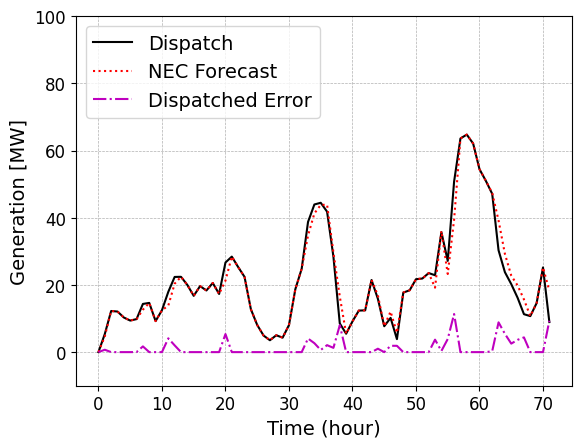

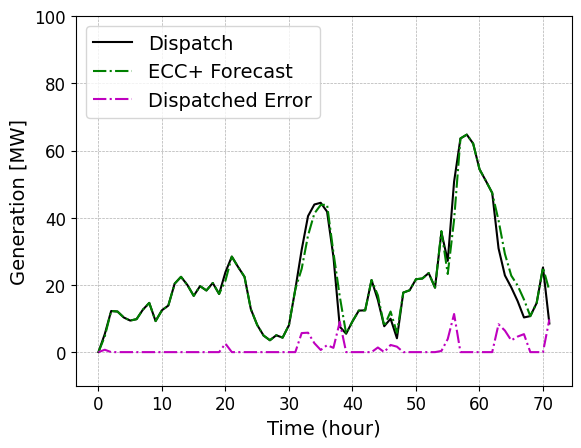

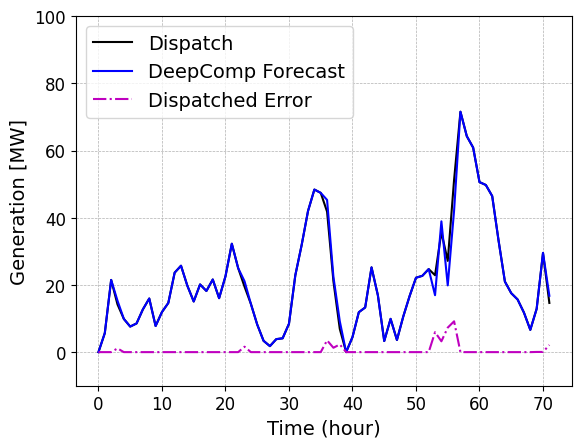

In [7]:
eg1 = 0
eg2 = 42.5
eg3 = 47.5
eg_len = 3

Pred0 = np.zeros((size_real0, len(model)))
Disp0 = np.zeros((size_real0, len(model)))
for i in range(len(Pred[E_maxi])):
    Pred0[hour[i+1],:] = Pred[E_maxi][i,:]
    Disp0[hour[i+1],:] = Disp[E_maxi][i,:]

fig_eg = [0 for M in range(len(Model))]
for M in range(len(Model)):
    j = model_name.index(Model[M])
    disp_eg = np.array(list(Disp0[int(24*eg1):int(24*(eg1+1)),j]) + list(Disp0[int(24*eg2):int(24*(eg2+1)),j]) + list(Disp0[int(24*eg3):int(24*(eg3+1)),j]))
    pred_eg = np.array(list(Pred0[int(24*eg1):int(24*(eg1+1)),j]) + list(Pred0[int(24*eg2):int(24*(eg2+1)),j]) + list(Pred0[int(24*eg3):int(24*(eg3+1)),j]))
    fig_eg[M] = plt.figure()
    plt.plot(RE_Capacity*disp_eg, 'k', linewidth=1.5, label="Dispatch")
    plt.plot(RE_Capacity*pred_eg, colorl[j], linewidth=1.5, label=model_name[j]+" Forecast")
    plt.plot(RE_Capacity*np.abs(disp_eg-pred_eg), 'm-.', linewidth=1.5, label="Dispatched Error")
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel("Time (hour)", fontsize=14)
    plt.ylabel("Generation [MW]", fontsize=14)
    plt.ylim([-10,100])
    plt.grid(linestyle='--', linewidth=0.5)
    plt.legend(fontsize=14, loc=2)
    plt.show()

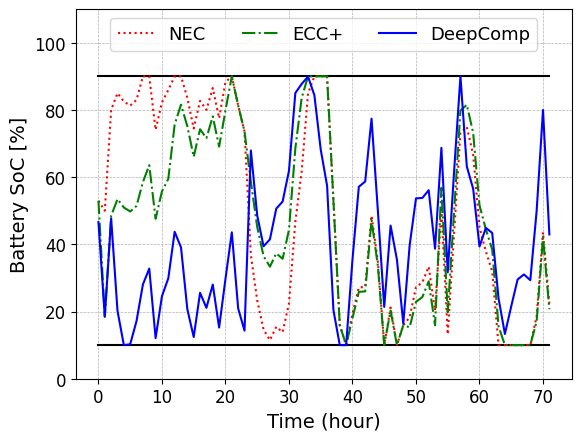

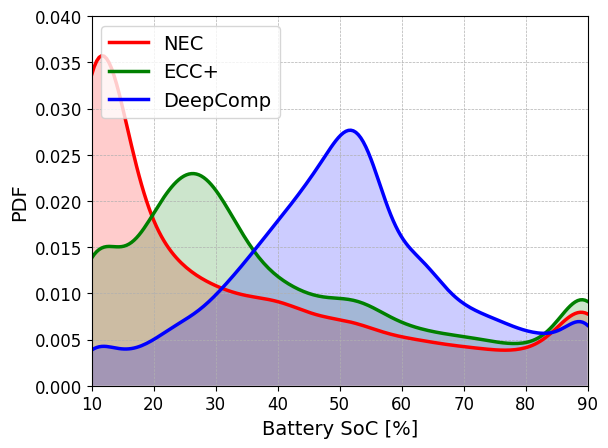

In [8]:
Ess0  = np.zeros((size_real0, len(model)))
for i in range(len(Pred[E_maxi])):
    Ess0[hour[i+1],:]  = Ess[E_maxi][i,:]
for i in range(len(Ess0)):
    if Ess0[i][0] == 0:
        Ess0[i,:] = Ess0[i-1,:]

fig_ess = plt.figure()
plt.plot([100*soc_max for _ in range(24*eg_len)], 'k', linewidth=1.5)
plt.plot([100*soc_min for _ in range(24*eg_len)], 'k', linewidth=1.5)
for M in range(len(Model)):
    j = model_name.index(Model[M])
    ess_eg = np.array(list(Ess0[int(24*eg1):int(24*(eg1+1)),j]) + list(Ess0[int(24*eg2):int(24*(eg2+1)),j]) + list(Ess0[int(24*eg3):int(24*(eg3+1)),j]))
    plt.plot(100*ess_eg/E_max, colorl[j], linewidth=1.5, label=model_name[j])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time (hour)", fontsize=14)
plt.ylabel("Battery SoC [%]", fontsize=14)
plt.ylim([0, 110])
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=13, loc=9, ncol=3)
plt.show()

xe = np.linspace(100*soc_min, 100*soc_max, 200)
pdf_SoC = []
for M in range(len(Model)):
    j = model_name.index(Model[M])
    pdf_SoC += [gaussian_kde(100*Ess0[:,j]/E_max)]

fig_pdf_SoC = plt.figure()
for M in range(len(Model)):
    j = model_name.index(Model[M])
    plt.plot(xe, pdf_SoC[M](xe), color[j], linewidth=2.5, label=Model[M])
    plt.fill_between(xe, pdf_SoC[M](xe), 0, facecolor=color[j], alpha=0.2)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Battery SoC [%]", fontsize=14)
plt.ylabel("PDF", fontsize=14)
plt.xlim([100*soc_min,100*soc_max])
plt.ylim([0, 0.04])
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=14, loc=2)
plt.show()